<a href="https://colab.research.google.com/github/pcutropia/Portafolio/blob/main/RobotTrading/Robot_Trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Configuración de Ambiente

##Variables Globales

In [1]:
global df_bitcoin, precio_actual, tendencia, media_bitcoin,  algoritmo_decision

##Importación de librerías

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime, timedelta
import pytz
from bs4 import BeautifulSoup
import requests

##Versión de librerías

In [3]:
!python -V
print('------')
!pip show Pandas | grep 'Name\|Version'
print('------')
!pip show Numpy | grep 'Name\|Version'
print('------')
!pip show Matplotlib | grep 'Name\|Version'

Python 3.10.12
------
Name: pandas
Version: 1.5.3
------
Name: numpy
Version: 1.23.5
------
Name: matplotlib
Version: 3.7.1


#Obtención de datos

##Importar historial bitcoin

In [21]:
def importar_base_bitcoin():
  global df_bitcoin
  date_end = datetime.now()
  date_start = date_end - timedelta(days = 7)
  df_bitcoin = yf.download("BTC-USD", interval="5m", end=date_end, start=date_start)
  #Conversión de dates al timezone
  df_bitcoin = df_bitcoin.tz_convert(pytz.timezone('America/Argentina/Buenos_Aires'))

##Extraer tendencias

In [97]:
def extraer_tendencias():
  global precio_actual, tendencia
  headers = {'User-Agent' : 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/118.0.0.0 Safari/537.36'}
  url = 'https://coinmarketcap.com/'
  respuesta = requests.get(url, headers=headers)
  s=BeautifulSoup(respuesta.content, features='lxml')
  precio_actual = float(s.find('div', {'class' : 'sc-a0353bbc-0'}).get_text().replace('$', '').replace(',', ''))
  tendencia = str(s.find('span', {'class' : 'sc-d55c02b-0'}))
  if ('up' in tendencia):
    tendencia = 'alta'
  elif ('down' in tendencia):
    tendencia = 'baja'

#Limpieza de datos

##Genera copia

In [46]:
df_bitcoin_limpio = df_bitcoin.copy()
df_bitcoin_limpio.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1916 entries, 2023-10-29 14:20:00-03:00 to 2023-11-05 14:15:00-03:00
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1916 non-null   float64
 1   High       1916 non-null   float64
 2   Low        1916 non-null   float64
 3   Close      1916 non-null   float64
 4   Adj Close  1916 non-null   float64
 5   Volume     1916 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 104.8 KB


##Eliminar índices duplicados

In [ ]:
df_bitcoin_limpio.index.drop_duplicates()

##Eliminar Close nulos

In [49]:
df_bitcoin_limpio.dropna(subset = ['Close'], inplace = True)

##Eliminar Volume <= 0

In [58]:
seleccion = df_bitcoin_limpio['Volume'] > 0
df_bitcoin_limpio = df_bitcoin_limpio[seleccion]

##Eliminar outliers Close

In [ ]:
df_bitcoin_limpio.boxplot(['Close'])

In [74]:
def elimina_outliers_close():
  global df_bitcoin_limpio
  close = df_bitcoin_limpio['Close']
  Q1 = close.quantile(.25)
  Q3 = close.quantile(.75)
  filtro = (Q1 <= close) & (close <= Q3)
  df_bitcoin_limpio = df_bitcoin_limpio[filtro]

##Get Close Media

In [68]:
df_bitcoin_limpio['Close'].mean()

34679.90881541419

##Función limpieza datos

In [79]:
def limpieza_datos():
  global df_bitcoin, media_bitcoin
  #Genera copia
  df_bitcoin_limpio = df_bitcoin.copy()
  #Eliminar índices duplicados
  df_bitcoin_limpio.index.drop_duplicates()
  #Eliminar Close nulos
  df_bitcoin_limpio.dropna(subset = ['Close'], inplace = True)
  #Eliminar Volume <= 0
  seleccion = df_bitcoin_limpio['Volume'] > 0
  df_bitcoin_limpio = df_bitcoin_limpio[seleccion]
  #Eliminar outliers Close
  elimina_outliers_close()
  #Get Close Media
  media_bitcoin = df_bitcoin_limpio['Close'].mean()

#Tomar decisiones

In [83]:
def tomar_decisiones():
  global precio_actual, tendencia, media_bitcoin, algoritmo_decision
  if ((precio_actual >= media_bitcoin) & (tendencia == 'baja')):
    algoritmo_decision = 'Vender'
  elif ((precio_actual < media_bitcoin) & (tendencia == 'alta')):
    algoritmo_decision = 'Comprar'
  else:
    algoritmo_decision = 'Esperar'

#Visualización

In [93]:
def visualizacion():
    global algoritmo_decision
    #Agrega media_bitcoin a df_bitcoin
    df_bitcoin['Promedio'] = media_bitcoin
    #Ajusta gráfico a 16x5
    plt.figure(figsize=(16, 5))
    #Titulo
    plt.title('Bitcoin & Mean')
    #Dibuja una línea en el gráfico, con los datos del índice y la columna Close de la base df_bitcoin
    plt.plot(df_bitcoin.index, df_bitcoin['Close'], label='Bitcoin')
    #Dibuja una línea en el gráfico, con los datos del índice y la columna Promedio de la base df_bitcoin.
    plt.plot(df_bitcoin.index, df_bitcoin['Promedio'], label='Promedio')
    #Coordenadas para la esquina superior derecha del gráfico
    #Última fecha de datos
    corner_x = df_bitcoin.index[-1]
    #Valor máximo entre 'Close' y 'Promedio'
    corner_y = max(df_bitcoin[['Close', 'Promedio']].max())
    #Configura las coordenadas xy y el texto a mostrar
    plt.annotate('Decisión del algoritmo: ' + algoritmo_decision,
                 #Coordenadas en la esquina superior derecha
                 xy=(corner_x, corner_y),
                 #Ajusta la posición del texto
                 xytext=(-0, 20),
                 #Configura el ajuste relativo a las coordenadas
                 textcoords='offset points',
                 fontsize=14)

    #Muestra en pantalla el gráfico configurado
    #Mostrar leyenda
    plt.legend()
    #Etiqueta del eje x
    plt.xlabel('Fecha')
    #Etiqueta del eje y
    plt.ylabel('Valor')
    #Mostrar cuadrícula
    plt.grid(True)
    plt.show()

#Automatización

[*********************100%%**********************]  1 of 1 completed
Precio Actual Bitcoin: 35123.46
Tendencia: alta
Valor Medio del Bitcoin: 34750.33978484331


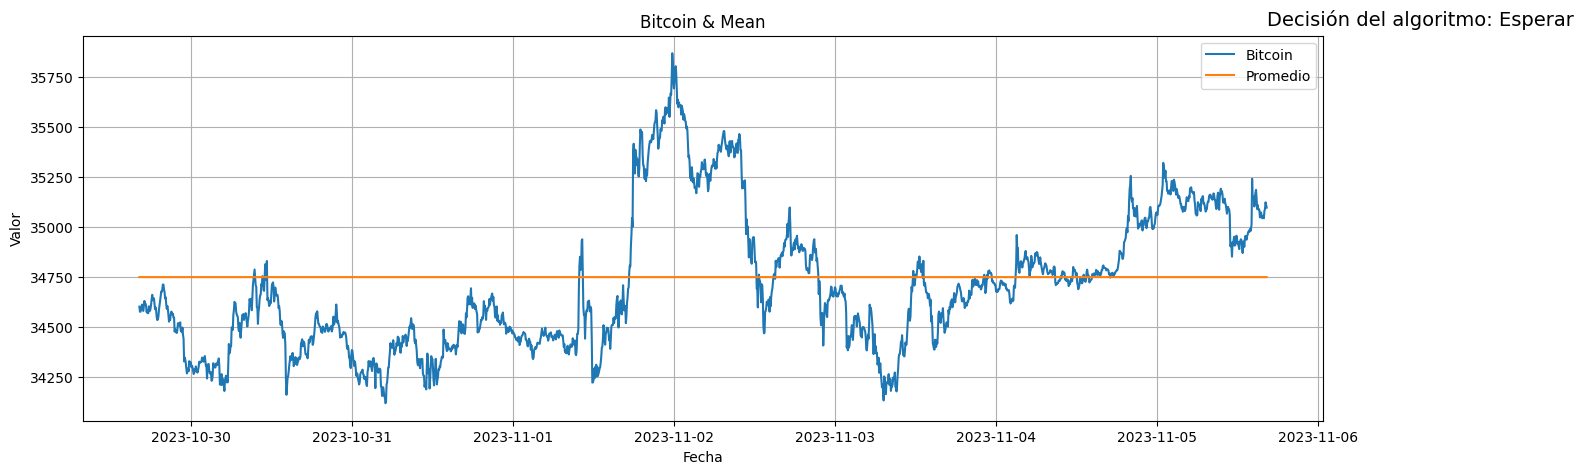

KeyboardInterrupt: ignored

In [98]:
from IPython.core.display import clear_output
import time
while(True):
  clear_output()
  importar_base_bitcoin()
  extraer_tendencias()
  limpieza_datos()
  tomar_decisiones()
  print("Precio Actual Bitcoin: " + str(precio_actual))
  print("Tendencia: " + tendencia)
  print("Valor Medio del Bitcoin: " + str(media_bitcoin))
  visualizacion()
  time.sleep(300)